# Árboles de decisión

## Imports

In [1]:
# importamos las librerias y bibliotecas que utilizaremos para el algoritmo árboles de desición
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import RobustScaler
from sklearn.impute import SimpleImputer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics import confusion_matrix, recall_score, f1_score, precision_score
from pandas import DataFrame

## Funciones auxiliares

In [2]:
# Construcción de una función que realice el particionado completo
def train_val_test_split(df, rstate=42, shuffle=True, stratify=None):
    strat = df[stratify] if stratify else None
    train_set, test_set = train_test_split(
        df, test_size=0.4, random_state=rstate, shuffle=shuffle, stratify=strat)
    strat = test_set[stratify] if stratify else None
    val_set, test_set = train_test_split(
        test_set, test_size=0.5, random_state=rstate, shuffle=shuffle, stratify=strat)
    return (train_set, val_set, test_set)

In [3]:
def evaluate_result(y_pred, y, y_prep_pred, y_prep, metric):
    print(metric.__name__, "WITHOUT preparation:", metric(y_pred, y, average='weighted'))
    print(metric.__name__, "WITH preparation:", metric(y_prep_pred, y_prep, average='weighted'))

## Lectura del conjunto de datos

In [4]:
#Lectura del dataset 
df = pd.read_csv('dataset-equilibrado-3.csv')

##  Visualización preliminar de la información

In [5]:
# Si dataset si posee colunmas categoricas ejecutamos la siguente funcion
df.head(5)

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,72918,Female,53.0,1,0,Yes,Private,Urban,62.55,30.3,Unknown,1
1,72911,Female,57.0,1,0,Yes,Private,Rural,129.54,60.9,smokes,0
2,72898,Female,67.0,1,1,Yes,Private,Rural,199.24,33.9,never smoked,1
3,72882,Male,47.0,0,0,Yes,Private,Rural,75.30,25.0,formerly smoked,0
4,72861,Female,52.0,0,0,Yes,Private,Urban,69.30,20.1,never smoked,0


In [6]:
#Validamos la cantidad de ejemplos que posee el dataset
df["stroke"].value_counts()

0    1600
1     783
Name: stroke, dtype: int64

## Primera preparación del conjunto de datos

In [7]:
df_new = pd.get_dummies(df, columns=['gender','ever_married','work_type','Residence_type','smoking_status'])

In [8]:
df_new

,id,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke,gender_Female,gender_Male,ever_married_No,...,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children,Residence_type_Rural,Residence_type_Urban,smoking_status_Unknown,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes
0,72918,53.0,1,0,62.55,30.3,1,1,0,0,...,0,1,0,0,0,1,1,0,0,0
1,72911,57.0,1,0,129.54,60.9,0,1,0,0,...,0,1,0,0,1,0,0,0,0,1
2,72898,67.0,1,1,199.24,33.9,1,1,0,0,...,0,1,0,0,1,0,0,0,1,0
3,72882,47.0,0,0,75.30,25.0,0,0,1,0,...,0,1,0,0,1,0,0,1,0,0
4,72861,52.0,0,0,69.30,20.1,0,1,0,0,...,0,1,0,0,0,1,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2378,132,80.0,0,0,84.86,NaN,0,1,0,0,...,0,0,0,0,0,1,1,0,0,0
2379,129,24.0,0,0,97.55,26.2,0,1,0,1,...,0,1,0,0,0,1,0,0,1,0
2380,99,31.0,0,0,108.89,52.3,0,1,0,1,...,0,1,0,0,0,1,1,0,0,0
2381,84,55.0,0,0,89.17,31.5,0,0,1,0,...,0,1,0,0,0,1,0,0,1,0


In [9]:
#Eliminamos datos que son irrelevantes y que podrian alterar el comportamiento del algoritmo
df_new = df_new.drop(["id"], axis=1)

## División del conjunto de datos

In [10]:
# Division del conjunto en los diferentes subconjuntos
train_set, val_set, test_set = train_val_test_split(df_new, stratify='stroke')

In [11]:
#Verificamos las particiones realizadas
print("Longitud del Training Set:", len(train_set))
print("Longitud del Validation Set:", len(val_set))
print("Longitud del Test Set:", len(test_set))

Longitud del Training Set: 1429
Longitud del Validation Set: 477
Longitud del Test Set: 477


In [12]:
# Conjunto de datos de entrenamiento
X_train = train_set.drop("stroke", axis=1)
y_train = train_set["stroke"].copy()

In [13]:
# Conjunto de datos de validación
X_val = val_set.drop("stroke", axis=1)
y_val = val_set["stroke"].copy()

In [14]:
# Conjunto de datos de pruebas
X_test = test_set.drop("stroke", axis=1)
y_test = test_set["stroke"].copy()

## Segunda preparación del conjunto de datos

In [15]:
# Rellenamos los valores nulos con la mediana
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy="median")

In [16]:
# Rellenamos los valores nulos
X_train_prep = imputer.fit_transform(X_train)
X_val_prep = imputer.fit_transform(X_val)
X_test_prep = imputer.fit_transform(X_test)

In [17]:
# Transformamos el resultado a un DataFrame de Pandas
X_train_prep = pd.DataFrame(X_train_prep, columns=X_train.columns, index=y_train.index)
X_val_prep = pd.DataFrame(X_val_prep, columns=X_val.columns, index=y_val.index)
X_test_prep = pd.DataFrame(X_test_prep, columns=X_test.columns, index=y_test.index)

In [18]:
#Validamos que los cambios se aplicaron correctamente 
X_train_prep

,age,hypertension,heart_disease,avg_glucose_level,bmi,gender_Female,gender_Male,ever_married_No,ever_married_Yes,work_type_Govt_job,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children,Residence_type_Rural,Residence_type_Urban,smoking_status_Unknown,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes
2082,42.0,0.0,0.0,86.07,27.3,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
2367,42.0,0.0,0.0,210.48,71.9,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
118,65.0,0.0,0.0,58.87,36.6,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
959,61.0,0.0,0.0,99.16,26.6,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
1592,35.0,0.0,0.0,108.08,30.6,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2370,12.0,0.0,0.0,75.22,20.9,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0
342,78.0,0.0,0.0,81.59,32.3,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
39,25.0,0.0,0.0,138.29,27.3,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
1486,31.0,0.0,0.0,88.78,35.8,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0


## Escalando el conjunto de datos

In [19]:
scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train_prep)

In [20]:
scaler = RobustScaler()
X_val_scaled = scaler.fit_transform(X_val_prep)

In [21]:
scaler = RobustScaler()
X_test_scaled = scaler.fit_transform(X_test_prep)

In [22]:
# Transformación a un DataFrame de Pandas
X_train_scaled = DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)
X_train_scaled.head(10)

,age,hypertension,heart_disease,avg_glucose_level,bmi,gender_Female,gender_Male,ever_married_No,ever_married_Yes,work_type_Govt_job,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children,Residence_type_Rural,Residence_type_Urban,smoking_status_Unknown,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes
2082,-0.315789,0.0,0.0,-0.197073,-0.141026,-1.0,1.0,0.0,0.0,0.0,0.0,-1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2367,-0.315789,0.0,0.0,2.230439,5.576923,-1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,-1.0,0.0,0.0,1.0,0.0
118,0.289474,0.0,0.0,-0.727805,1.051282,-1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
959,0.184211,0.0,0.0,0.058341,-0.230769,-1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1592,-0.500000,0.0,0.0,0.232390,0.282051,-1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,-1.0,0.0,1.0,0.0,0.0
2210,-0.526316,0.0,0.0,-0.188488,0.000000,-1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,-1.0,0.0,1.0,0.0,0.0
1336,0.052632,0.0,0.0,0.090927,-0.205128,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2190,0.026316,1.0,0.0,0.071220,0.743590,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,-1.0,0.0,0.0,1.0,0.0
339,0.500000,0.0,1.0,0.670829,-0.076923,-1.0,1.0,0.0,0.0,0.0,0.0,-1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1647,-1.105263,0.0,0.0,-0.217171,0.192308,0.0,0.0,1.0,-1.0,0.0,0.0,-1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0


## Árbol de decisión

In [23]:
from sklearn.tree import DecisionTreeClassifier

MAX_DEPTH = 20

# Modelo entrenado con el conjunto de datos sin escalar
clf_tree = DecisionTreeClassifier(max_depth=MAX_DEPTH, random_state=42)
clf_tree.fit(X_train_prep, y_train)

DecisionTreeClassifier(max_depth=20, random_state=42)

In [24]:
# Modelo entrenado con el conjunto de datos escalado
clf_tree_scaled = DecisionTreeClassifier(max_depth=MAX_DEPTH, random_state=42)
clf_tree_scaled.fit(X_train_scaled, y_train)

DecisionTreeClassifier(max_depth=20, random_state=42)

In [25]:
# Predecimos con el conjunto de datos de entrenamineto
y_train_pred = clf_tree.predict(X_train_prep)
y_train_prep_pred = clf_tree_scaled.predict(X_train_scaled)

In [26]:
clf_tree_scaled.score(X_train_prep, y_train)

0.5038488453463961

In [27]:
# Accuaricy del conjunto de datos sin escalar
print('Accuracy: {:.3f}'.format(accuracy_score(y_train, y_train_pred)))

Accuracy: 1.000


In [28]:
from sklearn.metrics import f1_score
print("F1 score:", f1_score(y_train, y_train_pred, pos_label=1))

F1 score: 1.0


In [29]:
# Accuaricy del conjunto de datos escalado
print('Accuracy: {:.3f}'.format(accuracy_score(y_train, y_train_prep_pred)))

Accuracy: 1.000


In [30]:
# Comparamos resultados entre escalado y sin escalar
evaluate_result(y_train_pred, y_train, y_train_prep_pred, y_train, f1_score)

f1_score WITHOUT preparation: 1.0
f1_score WITH preparation: 1.0


In [31]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train, y_train_pred)

array([[959,   0],
       [  0, 470]], dtype=int64)

In [32]:
# Predecimos con el conjunto de datos de validación
y_pred = clf_tree.predict(X_val_prep)
y_prep_pred = clf_tree_scaled.predict(X_val_scaled)

In [33]:
# Accuaricy del conjunto de datos sin escalar
print('Accuracy: {:.3f}'.format(accuracy_score(y_val, y_pred)))

Accuracy: 0.709


In [34]:
print("F1 score:", f1_score(y_val, y_pred, pos_label=1))

F1 score: 0.5382059800664452


In [35]:
# Accuaricy del conjunto de datos escalado
print('Accuracy: {:.3f}'.format(accuracy_score(y_val, y_prep_pred)))

Accuracy: 0.734


In [36]:
# Comparamos resultados entre escalado y sin escalar
evaluate_result(y_pred, y_val, y_prep_pred, y_val, f1_score)

f1_score WITHOUT preparation: 0.7119875200015666
f1_score WITH preparation: 0.7363360919461507


## Visualizando el limite de decision

In [37]:
# Reducimos el número de atributos del conjunto de datos para visualizarlo mejor
X_train_reduced = X_train_prep[['age', 'avg_glucose_level']]

In [38]:
# Generamos un modelo con el conjunto de datos reducido
clf_tree_reduced = DecisionTreeClassifier(max_depth=2, random_state=42)
clf_tree_reduced.fit(X_train_reduced, y_train)

DecisionTreeClassifier(max_depth=2, random_state=42)

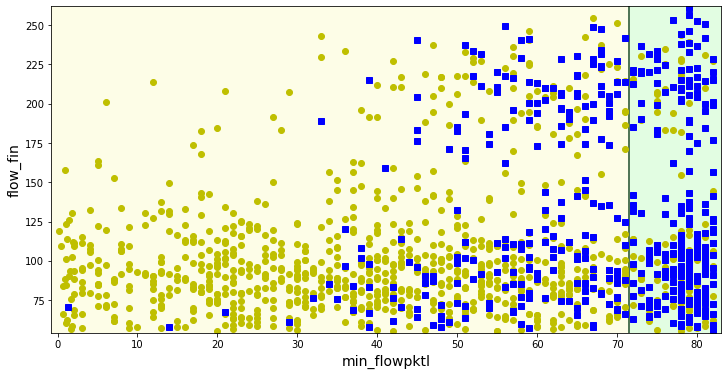

In [39]:
# Representamos gráficamente el límite de decisión construido
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
%matplotlib inline

def plot_decision_boundary(clf, X, y, plot_training=True, resolution=1000):
    mins = X.min(axis=0) - 1
    maxs = X.max(axis=0) + 1
    x1, x2 = np.meshgrid(np.linspace(mins[0], maxs[0], resolution),
                         np.linspace(mins[1], maxs[1], resolution))
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)
    custom_cmap = ListedColormap(['#fafab0','#9898ff','#a0faa0'])
    plt.contourf(x1, x2, y_pred, alpha=0.3, cmap=custom_cmap)
    custom_cmap2 = ListedColormap(['#7d7d58','#4c4c7f','#507d50'])
    plt.contour(x1, x2, y_pred, cmap=custom_cmap2, alpha=0.8)
    if plot_training:
        plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo", label=0)
        plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs", label=0)
        plt.axis([mins[0], maxs[0], mins[1], maxs[1]])               
    plt.xlabel('min_flowpktl', fontsize=14)
    plt.ylabel('flow_fin', fontsize=14, rotation=90)

plt.figure(figsize=(12, 6))
plot_decision_boundary(clf_tree_reduced, X_train_reduced.values, y_train)
plt.show()